In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py as h5

In [2]:
file = h5.File('../output/lcdm.h5')
# file.close()

In [3]:
p = file["potential"][:]

In [6]:
file.close()

In [4]:
def polygon_to_triangles(p):
    return np.c_[np.repeat(p[0], p.size - 2), p[1:-1], p[2:]]

class Mesh:
    def __init__(self, h5_group):
        """Initialize a mesh from a group in a HDF5 file."""
        self.vertices = h5_group['vertices'][:].astype('float64')
        data = h5_group['data'][:]
        sizes = h5_group['sizes'][:]
        self.info = h5_group['info'][:].astype('float64')
        i1 = np.cumsum(sizes)
        i0 = np.r_[[0], i1[:-1]].astype(np.uint)
        self.polygons = [data[i:j] for i, j in np.c_[i0, i1]]
    
    @property
    def triangles(self):
        return np.concatenate([polygon_to_triangles(p) for p in self.polygons])

In [31]:
nodes = [file[str(s)]["nodes"][:] for s in range(3)]

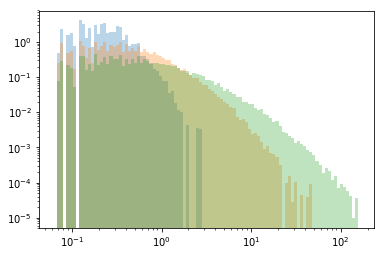

In [39]:
bins = np.logspace(-1.2, 2.2, 100)
fig, ax = plt.subplots(1, 1)
ax.set_xscale("log")
ax.set_yscale("log")

for i in range(3):
    ax.hist(nodes[i][np.where(nodes[i]['node_type'] == 4)]['mass'],
            bins=bins,
            log=True, density=True,
            alpha=0.3)

In [41]:
(np.sqrt(3) * 200.0 / 256)**2

1.8310546875